<a href="https://colab.research.google.com/github/jweon96/etf-rebalancing-portfolio/blob/main/static_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정적 리밸런싱

## 1️⃣ 데이터 수집
yfinance를 사용해 SPY, TLT, GLD의 2020-01-01 ~ 2024-12-31 종가 데이터를 가져옵니다.
auto_adjust=True 옵션을 통해 배당 및 분할이 반영된 가격을 사용합니다.

In [ ]:
!pip install yfinance

import yfinance as yf
import pandas as pd

# 설정
tickers = ['SPY', 'TLT', 'GLD']
start_date = '2020-01-01'
end_date = '2024-12-31'

# 데이터 수집
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True
)['Close'].dropna()

# 데이터 확인
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,GLD,SPY,TLT
Date,,,
2020-01-02,143.949997,299.406403,118.468452
2020-01-03,145.860001,297.139252,120.292908
2020-01-06,147.389999,298.272919,119.609764
2020-01-07,147.970001,297.434204,119.021828
2020-01-08,146.860001,299.019379,118.234962


## 2️⃣ 연 1회 리밸런싱 시뮬레이션
매년 1월 1일에 목표 비중(SPY 60%, TLT 30%, GLD 10%)으로 비중을 복원합니다.
초기 투자금은 $10,000으로 설정하고, 매 거래일마다 포트폴리오 가치를 계산합니다.

In [ ]:
import numpy as np

# 목표 비중 및 초기 자본
weights = {'SPY': 0.6, 'TLT': 0.3, 'GLD': 0.1}
initial_capital = 10000

# 초기 수량 계산
first_prices = data.iloc[0]
shares = {t: (initial_capital * weights[t]) / first_prices[t] for t in weights}

# 시뮬레이션 실행
portfolio_values = []

for date, prices in data.iterrows():
    # 포트폴리오 가치 계산
    port_value = sum(shares[t] * prices[t] for t in weights)
    portfolio_values.append(port_value)

    # 연 1회 리밸런싱: 1월 1일
    if date.month == 1 and date.day == 1:
        for t in weights:
            shares[t] = (port_value * weights[t]) / prices[t]

# 시리즈화
portfolio_series_annual = pd.Series(portfolio_values, index=data.index)

# 확인
portfolio_series_annual.head()

,0
Date,
2020-01-02,10000.000000
2020-01-03,10014.036649
2020-01-06,10030.084242
2020-01-07,10002.417454
2020-01-08,10006.546841


## 3️⃣ 연 + 밴드 리밸런싱 시뮬레이션 (±5%, ±10%)
연 1회 리밸런싱과 함께, 목표 비중에서 ±5% 또는 ±10% 이상 벗어나면 리밸런싱을 수행합니다.
각 밴드 전략의 포트폴리오 가치를 시뮬레이션합니다.


In [ ]:
# 함수: 연 + 밴드 리밸런싱 시뮬레이터
def simulate_annual_band(data, weights, band):
    first_prices = data.iloc[0]
    initial_capital = 10000
    shares = {t: (initial_capital * weights[t]) / first_prices[t] for t in weights}
    portfolio_values = []

    for date, prices in data.iterrows():
        port_value = sum(shares[t] * prices[t] for t in weights)
        portfolio_values.append(port_value)

        current_weights = {t: (shares[t] * prices[t]) / port_value for t in weights}

        rebalance = False

        # 연 1회 리밸런싱
        if date.month == 1 and date.day == 1:
            rebalance = True
        else:
            # 밴드 리밸런싱
            for t in weights:
                if abs(current_weights[t] - weights[t]) > band:
                    rebalance = True
                    break

        if rebalance:
            for t in weights:
                shares[t] = (port_value * weights[t]) / prices[t]

    return pd.Series(portfolio_values, index=data.index)

# 실행: ±5% 밴드
portfolio_series_band_5 = simulate_annual_band(data, weights, band=0.05)

# 실행: ±10% 밴드
portfolio_series_band_10 = simulate_annual_band(data, weights, band=0.10)

# 확인 (상위 5개)
portfolio_series_band_5.head(), portfolio_series_band_10.head()

(Date
 2020-01-02    10000.000000
 2020-01-03    10014.036649
 2020-01-06    10030.084242
 2020-01-07    10002.417454
 2020-01-08    10006.546841
 dtype: float64,
 Date
 2020-01-02    10000.000000
 2020-01-03    10014.036649
 2020-01-06    10030.084242
 2020-01-07    10002.417454
 2020-01-08    10006.546841
 dtype: float64)

## 4️⃣ 거래비용 반영
리밸런싱 시 매매 금액의 0.1%가 비용으로 차감됩니다.

In [ ]:
def simulate_rebalance_with_cost(data, weights, band=None, cost_rate=0.001):
    first_prices = data.iloc[0]
    initial_capital = 10000
    shares = {t: (initial_capital * weights[t]) / first_prices[t] for t in weights}
    portfolio_values = []
    turnovers = []

    for date, prices in data.iterrows():
        port_value = sum(shares[t] * prices[t] for t in weights)
        portfolio_values.append(port_value)

        current_weights = {t: (shares[t] * prices[t]) / port_value for t in weights}
        rebalance = False

        if date.month == 1 and date.day == 1:
            rebalance = True
        elif band is not None:
            for t in weights:
                if abs(current_weights[t] - weights[t]) > band:
                    rebalance = True
                    break

        if rebalance:
            current_values = {t: shares[t] * prices[t] for t in weights}
            target_values = {t: port_value * weights[t] for t in weights}
            turnover_amount = sum(abs(current_values[t] - target_values[t]) for t in weights)
            cost = turnover_amount * cost_rate
            port_value -= cost
            turnovers.append(turnover_amount)

            for t in weights:
                shares[t] = (port_value * weights[t]) / prices[t]
        else:
            turnovers.append(0.0)

    return pd.Series(portfolio_values, index=data.index), turnovers

# 연 1회 + 거래비용
portfolio_annual_cost, turnovers_annual = simulate_rebalance_with_cost(data, weights, band=None)

# 연 + 5% 밴드 + 거래비용
portfolio_band5_cost, turnovers_band5 = simulate_rebalance_with_cost(data, weights, band=0.05)

# 연 + 10% 밴드 + 거래비용
portfolio_band10_cost, turnovers_band10 = simulate_rebalance_with_cost(data, weights, band=0.10)

# 평균 거래 금액 출력
print(f"Average turnover per period (Annual only): ${np.mean(turnovers_annual):,.2f}")
print(f"Average turnover per period (5% band): ${np.mean(turnovers_band5):,.2f}")
print(f"Average turnover per period (10% band): ${np.mean(turnovers_band10):,.2f}")

Average turnover per period (Annual only): $0.00
Average turnover per period (5% band): $6.44
Average turnover per period (10% band): $5.66


### 💡 거래비용 총합 및 연평균 비용
아래는 각 전략에서 발생한 총 거래비용과 연평균 거래비용입니다.

In [ ]:
cost_rate = 0.001  # 0.1% 거래비용

In [ ]:
# 총 거래비용 (turnover 총합 x cost_rate)
total_cost_annual = np.sum(turnovers_annual) * cost_rate
total_cost_band5 = np.sum(turnovers_band5) * cost_rate
total_cost_band10 = np.sum(turnovers_band10) * cost_rate

# 출력
print(f"Annual Only + Cost 총 거래비용: ${total_cost_annual:,.2f}")
print(f"5% Band + Cost 총 거래비용: ${total_cost_band5:,.2f}")
print(f"10% Band + Cost 총 거래비용: ${total_cost_band10:,.2f}")

# 연평균 거래비용
years = (data.index[-1] - data.index[0]).days / 365.25
print(f"Annual Only + Cost 연평균 거래비용: ${total_cost_annual / years:,.2f}")
print(f"5% Band + Cost 연평균 거래비용: ${total_cost_band5 / years:,.2f}")
print(f"10% Band + Cost 연평균 거래비용: ${total_cost_band10 / years:,.2f}")

Annual Only + Cost 총 거래비용: $0.00
5% Band + Cost 총 거래비용: $8.09
10% Band + Cost 총 거래비용: $7.11
Annual Only + Cost 연평균 거래비용: $0.00
5% Band + Cost 연평균 거래비용: $1.62
10% Band + Cost 연평균 거래비용: $1.42


## 5️⃣ 성과지표 계산
각 전략(연 1회 + 거래비용, 연 + 5% 밴드 + 거래비용, 연 + 10% 밴드 + 거래비용)의 성과지표를 계산합니다.
성과지표: CAGR, Sharpe Ratio, Max Drawdown
Sharpe Ratio는 일간 수익률 기반 연환산 Sharpe를 계산합니다.

In [ ]:
def performance_metrics(ts):
    years = (ts.index[-1] - ts.index[0]).days / 365.25
    cagr = (ts.iloc[-1] / ts.iloc[0])**(1/years) - 1

    daily_ret = ts.pct_change().dropna()
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)

    roll_max = ts.cummax()
    max_dd = ((ts - roll_max) / roll_max).min()

    return {
        'CAGR': cagr,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd
    }

# 각 전략 성과지표 계산
metrics_annual = performance_metrics(portfolio_annual_cost)
metrics_band5 = performance_metrics(portfolio_band5_cost)
metrics_band10 = performance_metrics(portfolio_band10_cost)

# 출력
import pprint
pp = pprint.PrettyPrinter(indent=2)

print("\nPerformance (Annual only + cost):")
pp.pprint(metrics_annual)

print("\nPerformance (5% band + cost):")
pp.pprint(metrics_band5)

print("\nPerformance (10% band + cost):")
pp.pprint(metrics_band10)


Performance (Annual only + cost):
{ 'CAGR': np.float64(0.09276350537513989),
  'Max Drawdown': -0.2504576156689919,
  'Sharpe': np.float64(0.7371596501470751)}

Performance (5% band + cost):
{ 'CAGR': np.float64(0.0849684700992197),
  'Max Drawdown': -0.2533907507783629,
  'Sharpe': np.float64(0.6762503229753699)}

Performance (10% band + cost):
{ 'CAGR': np.float64(0.09487399054392265),
  'Max Drawdown': -0.25213945457338477,
  'Sharpe': np.float64(0.7352281897932614)}


## 6️⃣ 결과 시각화
전략별 포트폴리오 가치를 하나의 그래프로 비교합니다.

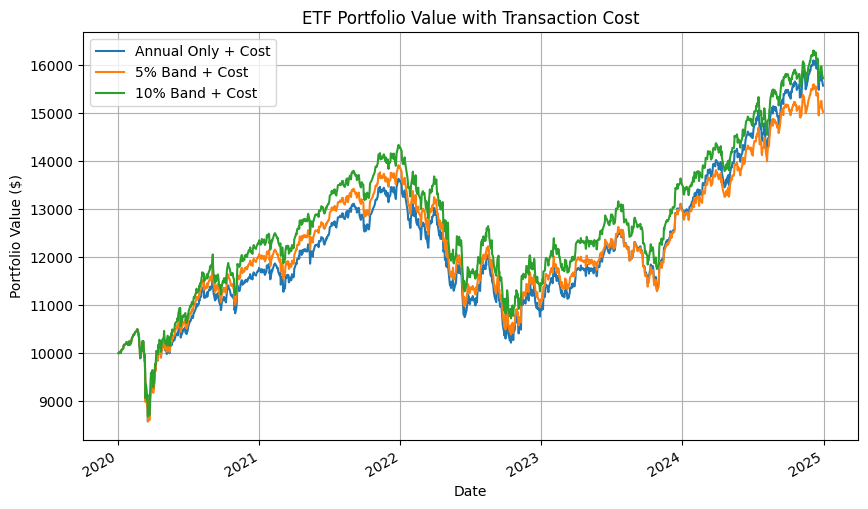

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
portfolio_annual_cost.plot(label='Annual Only + Cost')
portfolio_band5_cost.plot(label='5% Band + Cost')
portfolio_band10_cost.plot(label='10% Band + Cost')

plt.title('ETF Portfolio Value with Transaction Cost')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

## 7️⃣ 비교 전략 추가

### 7-1️⃣ Buy & Hold 전략 코드
초기 비중 (60% SPY, 30% TLT, 10% GLD)으로 투자 후 리밸런싱 없이 보유합니다.

In [ ]:
def simulate_buy_and_hold(data, weights):
    first_prices = data.iloc[0]
    initial_capital = 10000
    shares = {t: (initial_capital * weights[t]) / first_prices[t] for t in weights}
    portfolio_values = []

    for _, prices in data.iterrows():
        port_value = sum(shares[t] * prices[t] for t in weights)
        portfolio_values.append(port_value)

    return pd.Series(portfolio_values, index=data.index)

# 실행
portfolio_buy_hold = simulate_buy_and_hold(data, weights)

### 7-2️⃣ Buy & Hold 성과지표
Buy & Hold 전략의 성과지표를 계산하고 출력합니다.

In [ ]:
metrics_buy_hold = performance_metrics(portfolio_buy_hold)

import pprint
pp = pprint.PrettyPrinter(indent=2)
print("\nPerformance (Buy & Hold):")
pp.pprint(metrics_buy_hold)


Performance (Buy & Hold):
{ 'CAGR': np.float64(0.09276350537513989),
  'Max Drawdown': -0.2504576156689919,
  'Sharpe': np.float64(0.7371596501470751)}


### 7-3️⃣ 그래프 비교
Buy & Hold와 기존 리밸런싱 전략을 한 그래프에서 비교합니다.

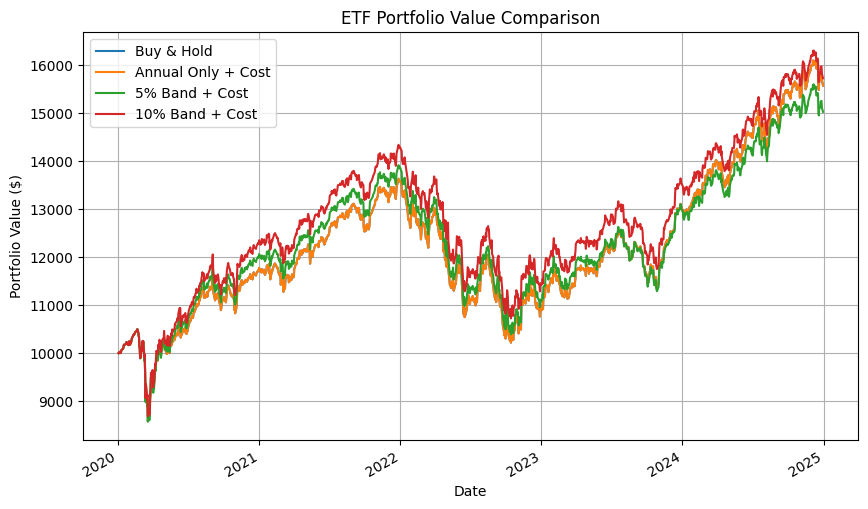

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
portfolio_buy_hold.plot(label='Buy & Hold')
portfolio_annual_cost.plot(label='Annual Only + Cost')
portfolio_band5_cost.plot(label='5% Band + Cost')
portfolio_band10_cost.plot(label='10% Band + Cost')

plt.title('ETF Portfolio Value Comparison')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### ⚠ Annual Only + Cost 전략과 Buy & Hold 전략의 동일 결과
본 분석에서 Annual Only + Cost 전략은 매년 1월 1일에 리밸런싱 조건이 적용되도록 설계되었습니다.  
그러나 시뮬레이션 결과, Buy & Hold와 Annual Only + Cost의 포트폴리오 가치 궤적이 완전히 일치하였습니다.

이는 연 1회 리밸런싱 시점에 실제 비중과 목표 비중이 거의 일치하여  
매매가 필요하지 않았거나, 거래비용이 발생하지 않을 만큼 미미한 매매였기 때문입니다.  

따라서 Annual Only + Cost 전략은 Buy & Hold와 동일한 결과로 분석되었습니다.

## 💡 다음 확장 아이디어
- 변동성 기반 동적 밴드 리밸런싱
- 간단한 ML 기반 리밸런싱 트리거
- Streamlit 대시보드로 시뮬레이션 데모 제공